<a href="https://colab.research.google.com/github/chinge55/nepali-currency-recognition/blob/master/Currency_Recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chinge55/nepali-currency-recognition

fatal: destination path 'nepali-currency-recognition' already exists and is not an empty directory.


In [2]:
import os
base_dir = 'nepali-currency-recognition/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_ten_dir = os.path.join(train_dir, 'ten')
train_fifty_dir = os.path.join(train_dir, 'fifty')
train_hundred_dir = os.path.join(train_dir, 'hundred')
test_ten_dir = os.path.join(test_dir, 'ten')
test_fifty_dir = os.path.join(test_dir, 'fifty')
test_hundred_dir = os.path.join(test_dir, 'hundred')


In [3]:
!mv nepali-currency-recognition/data/test/hundred/hundred.jpg nepali-currency-recognition/data/train/hundred/hundred.jpg

mv: cannot stat 'nepali-currency-recognition/data/test/hundred/hundred.jpg': No such file or directory


In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split = 0.2)
test_datagen = ImageDataGenerator(validation_split = 0.2)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def get_callbacks(model_name):
  checkpoint_path = 'model_checkpoints/checkpoint'+ model_name
  checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                             save_weights_only = True,
                             verbose = 1,
                             save_best_only = True
                            )
  early_stopper = EarlyStopping(monitor = 'loss',
                              patience = 5,
                              mode = 'auto')
  return (checkpoint, early_stopper)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical', subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical', subset = 'validation')
test_generator = train_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical')

Found 81 images belonging to 3 classes.
Found 19 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


In [7]:
IMG_SIZE = 150

In [8]:
num_classes = train_generator.num_classes
print(num_classes)

3


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [10]:
image, label = next(iter(train_generator))

Seems like the images need to be rescaled before plotting.

I am using a tensorflow layer to do the rescaling but it could be done in any ways. (Just divide every pixel by 255)

As I can see, there is a lack of data in this dataset. So, the best option is to create more datasets using data augmentation. 

I am using tensorflow layer for this task for this too.

Okay, that looks pretty neat but that is still not enough

In [11]:
class RandomPreprocess(layers.Layer):
  def __init__(self, factor = 0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
    self.rescale = layers.experimental.preprocessing.Rescaling(1./255)
  def random_rotate_img(self, x):
    if  tf.random.uniform([]) < self.factor:
      x = tf.image.rot90(x)
    else:
      x
    return x
  def random_flip_img(self, x):
    x = tf.image.random_flip_left_right(x)
    return x
  def random_crop_pad(self, x):
    x = tf.image.resize_with_crop_or_pad(x, IMG_SIZE + 6, IMG_SIZE + 6) 
    x = tf.image.random_crop(x, size = [IMG_SIZE, IMG_SIZE, 3] )
    return x
  def call(self, X):
    output_list = []
    for i in range(X.shape[0]):
      x = X[i]
      x = self.random_rotate_img(x) 
      x = self.random_flip_img(x)
      x = self.random_crop_pad(x)
      x = self.rescale(x)
      output_list.append(x)
    return tf.stack(output_list)

In [12]:
random_images = RandomPreprocess()(image)
random_images.shape

TensorShape([10, 150, 150, 3])

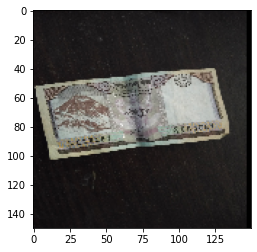

In [13]:
_ = plt.imshow(random_images[0])

In [14]:
#_ = plt.imshow((RandomPreprocess()(image)[0]))

In [15]:
# import tensorflow as tf
# class CustomModel(tf.keras.Model):
#   def __init__(self, units = 32):
#     super(CustomModel, self).__init__()
#     self.units = units
#     self.preprocessor = RandomPreprocess()
#     self.conv1 = layers.Conv2D(32, (3,3), activation = 'relu')
#     self.maxpool = layers.MaxPooling2D((2,2))
#     self.flatten = layers.Flatten()
#     self.dense = layers.Dense(units, activation = 'relu')
#     self.end_layer = layers.Dense(3, activation = 'softmax')
#   def call(self, x):
#     x = self.preprocessor(x)
#     x = self.conv1(x)
#     x = self.maxpool(x)
#     x = self.flatten(x)
#     x = self.dense(x)
#     x = self.end_layer(x)
#     return x

In [16]:
from keras import layers
from keras import models
model = models.Sequential()

In [17]:
model.add(RandomPreprocess())
model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax'))

In [18]:
from keras import optimizers
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
# INPUT_SHAPE = (None, 150, 150, 3)
# model.build(INPUT_SHAPE)
# model.summary()

In [19]:
history = model.fit(train_generator,epochs = 20, callbacks = [get_callbacks('model_dense')], validation_data = validation_generator)


Epoch 1/100


InvalidArgumentError: ignored

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(history.history['accuracy'])+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1. Implement Callbacks and EarlyStopping
2. Create a Custom Data generator
3. Change the model 
4. Use validation data for the custom datagenerator
